# Анализ бизнес-показателей

## Цель проекта:

Наша задача - помочь маркетологам приложения для покупки билетов оптимизировать маркетинговые затраты. В нашем распоряжении следующие данные:
   - лог сервера с данными о посещениях сайта 
   - выгрузка всех заказов за этот период
   - статистика рекламных расходов.
   
## План проекта:

1. Загрузка и предобработка данных

2. Составление отчетов и расчет метрик
    
      2.1. Продукт    
      
     - Сколько людей пользуются в день, неделю, месяц?
     - Сколько сессий в день?
     - Сколько длится одна сессия?
     - Как часто люди возвращаются?
     
   2.2. Продажи
    
     - Когда люди начинают покупать?
     - Сколько раз покупают за период?
     - Какой средний чек?
     - Сколько денег приносят? (LTV)
     
   2.3. Маркетинг
    
     - Сколько денег потратили? Всего / на каждый источник / по времени
     - Сколько стоило привлечение одного покупателя из каждого источника?
     - На сколько окупились расходы? (ROI)
     
     
3. Итоговые выводы

## 1. Загрузка и предобработка данных

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt

costs = pd.read_csv('/datasets/costs.csv')
orders = pd.read_csv('/datasets/orders_log.csv')
visits = pd.read_csv('/datasets/visits_log.csv')

Проверим названия столбцов

In [2]:
print(costs.columns)
print(visits.columns)
print(orders.columns)

Index(['source_id', 'dt', 'costs'], dtype='object')
Index(['Device', 'End Ts', 'Source Id', 'Start Ts', 'Uid'], dtype='object')
Index(['Buy Ts', 'Revenue', 'Uid'], dtype='object')


Для дальнейшего удобства приведем названия столбцов к нижнему регистру и избавимся от пробелов

In [3]:
frames = [costs, orders, visits]
for frame in frames:
  frame.columns = [x.strip().replace(' ', '_') for x in frame.columns]
  frame.columns = map(str.lower, frame.columns)

Посмотрим на общую информацию о датасетах

In [4]:
print('Датасет затрат')
costs.info()
print()
print('Датасет заказов')
orders.info()
print()
print('Датасет посещений')
visits.info()

Датасет затрат
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2542 entries, 0 to 2541
Data columns (total 3 columns):
source_id    2542 non-null int64
dt           2542 non-null object
costs        2542 non-null float64
dtypes: float64(1), int64(1), object(1)
memory usage: 59.7+ KB

Датасет заказов
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50415 entries, 0 to 50414
Data columns (total 3 columns):
buy_ts     50415 non-null object
revenue    50415 non-null float64
uid        50415 non-null uint64
dtypes: float64(1), object(1), uint64(1)
memory usage: 1.2+ MB

Датасет посещений
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 359400 entries, 0 to 359399
Data columns (total 5 columns):
device       359400 non-null object
end_ts       359400 non-null object
source_id    359400 non-null int64
start_ts     359400 non-null object
uid          359400 non-null uint64
dtypes: int64(1), object(3), uint64(1)
memory usage: 13.7+ MB


Необходимо перевести переменные даты в формат даты

In [5]:
costs['dt'] = pd.to_datetime(costs['dt'])

orders['buy_ts'] = pd.to_datetime(orders['buy_ts'])

visits['end_ts'] = pd.to_datetime(visits['end_ts'])
visits['start_ts'] = pd.to_datetime(visits['start_ts'])

Посмотрим на данные

In [6]:
costs.sample(5)

,source_id,dt,costs
427,2,2017-08-04,70.81
622,2,2018-02-15,181.31
1141,4,2017-07-23,42.18
747,3,2017-06-22,372.50
2104,9,2018-03-16,11.74


In [7]:
orders.sample(5)

,buy_ts,revenue,uid
42651,2018-03-28 22:43:00,0.92,2964186607958959187
17357,2017-11-13 19:28:00,2.14,820679401690803923
40734,2018-03-20 10:32:00,5.32,9781675919903538365
1639,2017-06-19 12:17:00,2.44,2146708860333158568
4069,2017-07-20 19:29:00,4.89,2162248437829538720


In [8]:
visits.sample(5)

,device,end_ts,source_id,start_ts,uid
220601,desktop,2017-09-27 16:06:00,5,2017-09-27 15:35:00,3262165627869261636
250153,desktop,2018-01-27 15:45:00,2,2018-01-27 15:43:00,13121447948659608730
216495,desktop,2018-02-01 14:12:00,3,2018-02-01 14:12:00,15557142551641108257
221937,desktop,2018-05-24 08:15:00,4,2018-05-24 07:38:00,1401649632827350542
313823,touch,2018-04-11 19:18:00,4,2018-04-11 19:10:00,7299189121249794001


Проверим на наличие дубликатов

In [9]:
print('Количество дубликатов в датасете costs {}'.format(costs.duplicated().sum()))
print('Количество дубликатов в датасете orders {}'.format(orders.duplicated().sum()))
print('Количество дубликатов в датасете visits {}'.format(visits.duplicated().sum()))

Количество дубликатов в датасете costs 0
Количество дубликатов в датасете orders 0
Количество дубликатов в датасете visits 0


Данные готовы к дальнейшему анализу

## 2. Составление отчетов и расчет метрик

### 2.1. Продукт 

### Сколько людей пользуются в день, неделю, месяц?

In [10]:
#для удобства буду работать с копией датасета
df1 = visits.copy()

df1['session_year']  = df1['start_ts'].dt.year
df1['session_month'] = df1['start_ts'].dt.month
df1['session_week']  = df1['start_ts'].dt.week
df1['session_date'] = df1['start_ts'].dt.date

dau_total = df1.groupby('session_date').agg({'uid': 'nunique'}).mean()
wau_total = df1.groupby(['session_year', 'session_week']).agg({'uid': 'nunique'}).mean()
mau_total = df1.groupby(['session_year', 'session_month']).agg({'uid': 'nunique'}).mean()

In [11]:
print('Количество уникальных пользователей')
print()
print('в день:', int(dau_total))
print('в неделю: ', int(wau_total))
print('в месяц: ', int(mau_total))

Количество уникальных пользователей

в день: 907
в неделю:  5716
в месяц:  23228


In [12]:
#получим некоторые переменные, необходимые для построения тепловой карты и дальнешего когортного анализа
first_activity_date = df1.groupby(['uid'])['start_ts'].min().astype('datetime64[M]')
first_activity_date.name = 'first_visit_month'
df1 = df1.join(first_activity_date,on='uid')
df1['visit_month'] = df1['start_ts'].astype('datetime64[M]')

In [13]:
sorce_month = df1.pivot_table(index='visit_month',
    columns='source_id',
    values='uid',
    aggfunc='nunique') 

In [14]:
#сохраню месяцы для дальнейших тепловых карт
for_heatmap = sorce_month.reset_index()['visit_month']

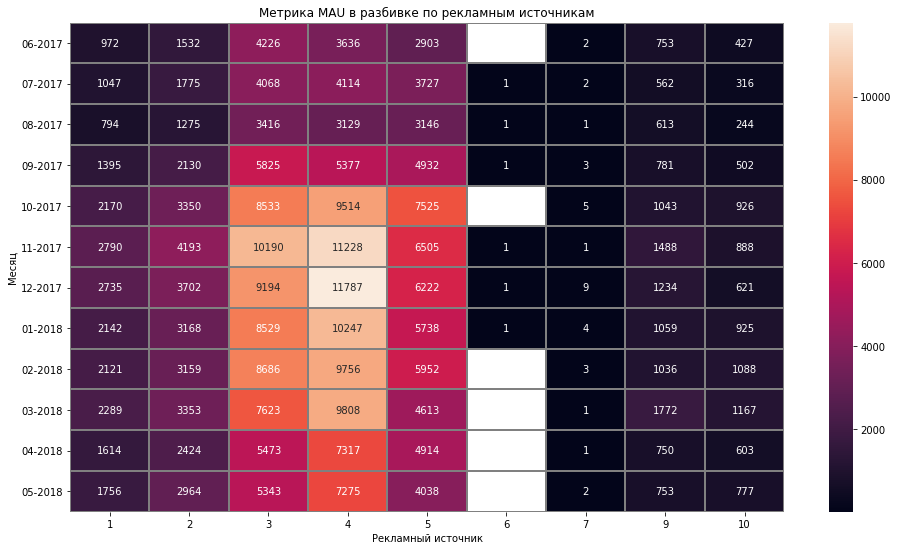

In [15]:
plt.figure(figsize=(16, 9))
plt.title('Метрика MAU в разбивке по рекламным источникам')
ax = sns.heatmap(sorce_month, annot=True, fmt='.5g', linewidths=1, linecolor='gray')
ax.set_yticklabels(for_heatmap.dt.strftime('%m-%Y'),rotation=0)
ax.set_ylabel('Месяц')
ax.set_xlabel('Рекламный источник')
plt.show()

### Сколько сессий в день?

In [16]:
#сгруппируем данные по дням и выведем количество сессий и уникальных пользователей
sessions_per_user = df1.groupby(['session_date']).agg({'uid': ['count','nunique']})
sessions_per_user.columns = ['n_sessions', 'n_users']

#рассчитаем количество сессий на пользователя
sessions_per_user['sess_per_user'] = sessions_per_user['n_sessions']/sessions_per_user['n_users']

In [17]:
print('Среднее количество сессий в день: {:.2f}'.format(sessions_per_user['sess_per_user'].mean()))

Среднее количество сессий в день: 1.08


Ожидаемый результат для приложения по покупке билетов.

### Сколько длится одна сессия?

In [18]:
#посчитаем разность между концом и началом сессии, округлим результат до целого и преведем к типу int
df1['session_duration_min'] = (
    ((df1['end_ts'] - df1['start_ts'])/np.timedelta64(1,'m'))
    .round().astype('int')
)

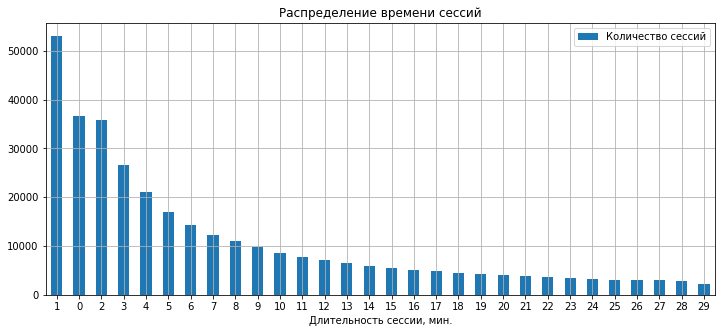

In [19]:
ax = (df1['session_duration_min'].value_counts().head(30).plot(kind = 'bar',grid = True, figsize = (12,5)))

ax.legend(['Количество сессий'])
ax.set_title('Распределение времени сессий')
ax.set_xlabel('Длительность сессии, мин.')
ax.set_xticklabels(ax.get_xticklabels(), rotation = 0)
plt.show()

In [20]:
less_than_30min = df1['session_duration_min'].value_counts(normalize=True).head(30).sum()
print('Доля сессий менее 30 минут - {:.0%}'.format(less_than_30min))

Доля сессий менее 30 минут - 92%


In [21]:
print('Половина посещений длится менее {:.0f} минут'.format(df1['session_duration_min'].median()))

Половина посещений длится менее 5 минут


Если учесть, что пользователи приходят из других источников, скорее всего по рекламе мероприятия, то 5 минут должно хватить на решение о покупке или об отказе

### Как часто люди возвращаются?

In [22]:
#получим датасет с месяцем первого посещения, месяцем посещения и количеством пользователей
df1_cohorts = df1.groupby(['first_visit_month','visit_month']).agg({'uid':'nunique'}).reset_index()

In [23]:
#посчитаем переменную lifetime
df1_cohorts['cohort_lifetime'] = (df1_cohorts['visit_month'] - df1_cohorts['first_visit_month'])/ np.timedelta64(1,'M')
df1_cohorts['cohort_lifetime'] = df1_cohorts['cohort_lifetime'].round().astype('int')

In [24]:
#отдельно получим количество поьзователей для lifetime равной 0
initial_users_count = df1_cohorts[df1_cohorts['cohort_lifetime'] == 0][['first_visit_month','uid']]
initial_users_count = initial_users_count.rename(columns={'uid':'cohort_users'}) 

In [25]:
#добавим переменную количества пользователей с lifetime=0 к датасету df1_cohorts
df1_cohorts = df1_cohorts.merge(initial_users_count,on='first_visit_month') 

#расчитаем процент возрата пользователей
df1_cohorts['retention'] = df1_cohorts['uid']/df1_cohorts['cohort_users']
retention_pivot = (
    df1_cohorts.
    pivot_table(index='first_visit_month',columns='cohort_lifetime',values='retention',aggfunc='sum') 
)

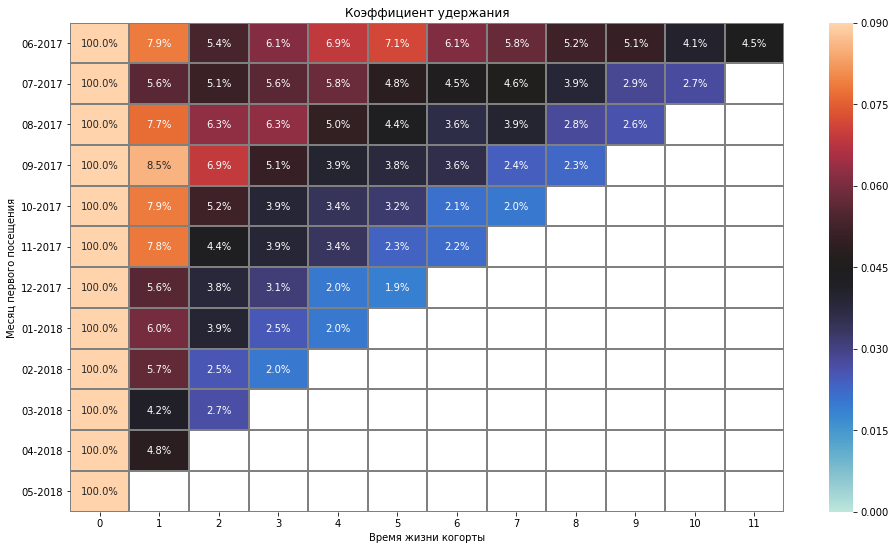

In [26]:
#посторим тепловую карту для показателя retention rate
plt.figure(figsize=(16, 9))
plt.title('Коэффициент удержания')
ax = sns.heatmap(retention_pivot, annot=True, fmt='.1%', linewidths=1, linecolor='gray', vmin=-0, vmax=0.09, center= 0.045)
ax.set_yticklabels(for_heatmap.dt.strftime('%m-%Y'))
ax.set_ylabel('Месяц первого посещения')
ax.set_xlabel('Время жизни когорты')
plt.show()

По тепловой карте можно сказать следующее:

   - больше всего пользователей вернулось с первой когорты
   - учитывая, что на графике времени сессии нет выбросов, т.е. скорее всего сервис функционирует отлично, уменьшение посещаемости носит сезонный характер
   - по коэффициенту удержания самыми успешными оказались когорты июня (первая когорта), августа, сентября, октября и ноября

## 2.2. Продажи

### Когда люди начинают покупать?

In [27]:
#расчет будем производить по аналогии с расчетом времени сессии
order_visit = visits.merge(orders,on='uid')
user_purch = order_visit.groupby('uid')[['start_ts','buy_ts']].min().reset_index()
user_purch['time_to_buy'] = (
    ((user_purch['buy_ts'] - user_purch['start_ts'])/np.timedelta64(1,'m')).
    round().astype('int')
)

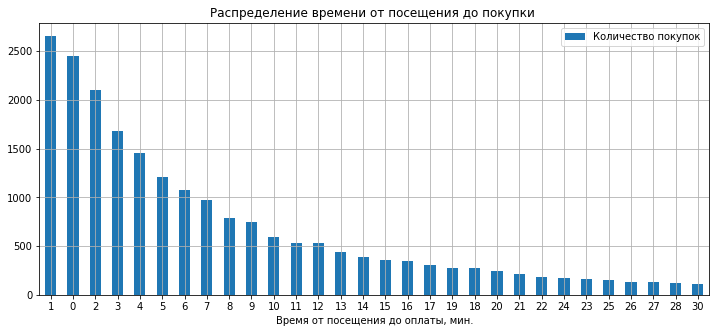

In [28]:
ax = (user_purch['time_to_buy'].value_counts().head(30).plot(kind = 'bar',grid = True, figsize = (12,5)))

ax.legend(['Количество покупок'])
ax.set_title('Распределение времени от посещения до покупки ')
ax.set_xlabel('Время от посещения до оплаты, мин.')
ax.set_xticklabels(ax.get_xticklabels(), rotation = 0)
plt.show()

Вывод:

   - Довольно много покупок совершается в первые 5 минут, наверное, пользователям ничто не мешает зайти толькодля того, чтобы оплатить покупку

### Сколько раз покупают за период?

Для расчета данной метрики применим когортный анализ

In [29]:
#в качестве когорты возьмем месяц совершения покупки
orders['buy_month'] = orders['buy_ts'].astype('datetime64[M]')
costs['month'] = costs['dt'].astype('datetime64[M]') 

In [30]:
#исключим покупки за июнь 2018 года, т.к. таких покупок всего одна и она ничего не изменит в дальнейшей работе
orders = orders.drop(orders.loc[orders['buy_month'] == '2018-06-01'].index)

In [31]:
#получим первый месяц покупки для каждого пользователя
first_buy_month = orders.groupby('uid').agg({'buy_month': 'min'}).reset_index()
first_buy_month.columns = ['uid', 'first_buy_month']

In [32]:
#посчитаем количество покупок для каждой когорты
cohort_sizes = first_buy_month.groupby('first_buy_month').agg({'uid': 'nunique'}).reset_index()
cohort_sizes.columns = ['first_buy_month', 'n_buyers']

In [33]:
#объеденим датасеты
orders_new = pd.merge(orders,first_buy_month, on='uid')

In [34]:
#расчитаем "возраст" когорты
orders_new['age'] = ((orders_new['buy_month'] - orders_new['first_buy_month']) / np.timedelta64(1, 'M')).round().astype('int')

In [35]:
#построим сводную таблицу когортного анализа по количеству продаж
output_sales = orders_new.pivot_table(
        index='first_buy_month', 
        columns='age', 
        values='uid', 
        aggfunc='count')

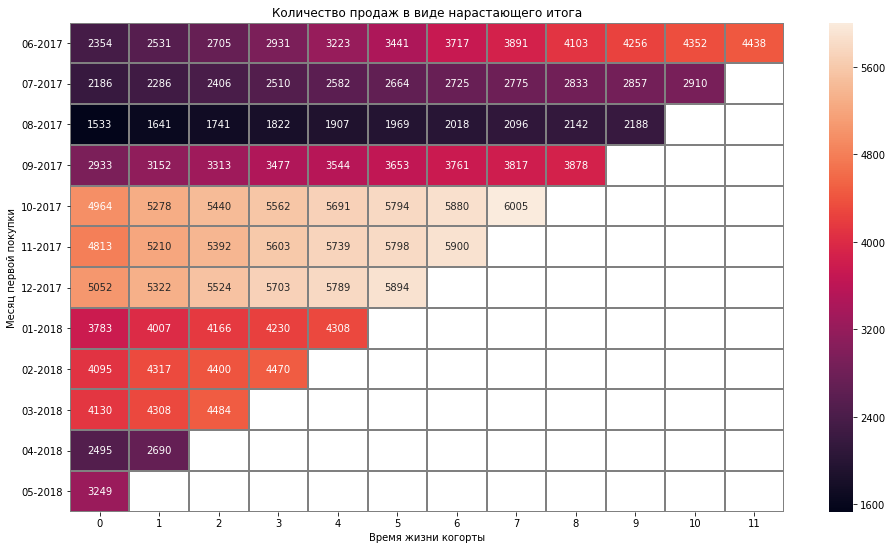

In [36]:
plt.figure(figsize=(16, 9))
plt.title('Количество продаж в виде нарастающего итога')
ax = sns.heatmap(output_sales.cumsum(axis=1).round() , annot=True, linewidths=1, fmt='.4g',linecolor='gray')
ax.set_yticklabels(for_heatmap.dt.strftime('%m-%Y'))
ax.set_ylabel('Месяц первой покупки')
ax.set_xlabel('Время жизни когорты')
plt.show()

In [37]:
print('В среднем, покупатель совершает {:.2f} покупок за весь период'.format(orders['uid'].value_counts().mean()))

В среднем, покупатель совершает 1.38 покупок за весь период


Выводы:

   - больше всего продаж было совершено с `октября` по `декабрь 2017 года`
   - `первая когорта` оказалась самой активной в плане совершения покупок
   - по тепловой карте отчетливо наблюдается сезонность покупок: в `июне - сентябре` времяпровождение на открытом воздухе более предпочтительно нежели в кино, театре и т.д.; `октябрь - декабрь` уже больше подходят для мероприятий в закрытых поещениях; в `феврале - марте` имеются праздники, которые могут являться причиной покупки билет в виде подарков

### Какой средний чек?

Просто возьмем среднее по переменной выручки

In [38]:
print('Средний чек составляет {:.2f}'.format(orders['revenue'].mean())) 

Средний чек составляет 5.00


### Сколько денег приносят? (LTV)

In [40]:
cohort_ltv = orders_new.groupby(['first_buy_month','buy_month']).agg({'revenue': 'sum'}).reset_index()

In [41]:
cohort_ltv_full = pd.merge(cohort_ltv,cohort_sizes, on='first_buy_month')

In [42]:
#маржинальность возьмем равной 100%
cohort_ltv_full['gp'] = cohort_ltv_full['revenue'] * 1
cohort_ltv_full['age'] = (cohort_ltv_full['buy_month'] - cohort_ltv_full['first_buy_month']) / np.timedelta64(1, 'M')
cohort_ltv_full['age'] = cohort_ltv_full['age'].round().astype('int')

In [43]:
cohort_ltv_full['ltv'] = cohort_ltv_full['gp'] / cohort_ltv_full['n_buyers']
    
output_ltv = cohort_ltv_full.pivot_table(
        index='first_buy_month', 
        columns='age', 
        values='ltv', 
        aggfunc='mean').cumsum(axis=1)

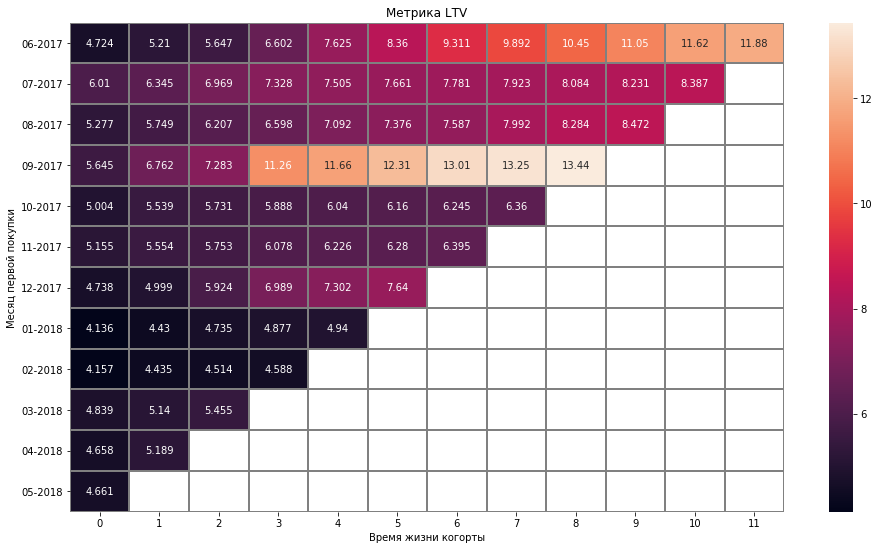

In [44]:
plt.figure(figsize=(16, 9))
plt.title('Метрика LTV')
ax = sns.heatmap(output_ltv, annot=True, linewidths=1, fmt='.4g',linecolor='gray')
ax.set_yticklabels(for_heatmap.dt.strftime('%m-%Y'))
ax.set_ylabel('Месяц первой покупки')
ax.set_xlabel('Время жизни когорты')
plt.show()

Выводы:

   - Больше всего денег принесли когорты июня и сентября 2017 года

##  2.3. Маркетинг

### Сколько денег потратили? Всего / на каждый источник / по времени

In [45]:
print('Всего за весь период было потрачено {}'.format(costs['costs'].sum()))

Всего за весь период было потрачено 329131.62


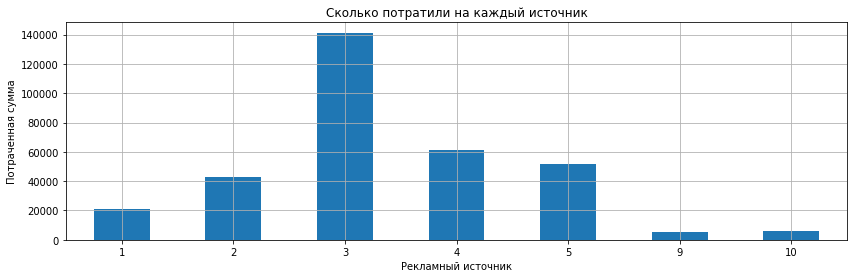

In [46]:
ax = costs.groupby('source_id')['costs'].sum().plot(kind = 'bar', figsize = (14,4), grid = True)

ax.set_title('Сколько потратили на каждый источник')
ax.set_xlabel('Рекламный источник')
ax.set_ylabel('Потраченная сумма')
ax.set_xticklabels(ax.get_xticklabels(), rotation = 0)
plt.show()

In [47]:
costs['month'] = costs['dt'].astype('datetime64[M]') 

In [48]:
source_month_pivot = costs.pivot_table(index = 'month', columns = 'source_id', values = 'costs', aggfunc = 'sum')

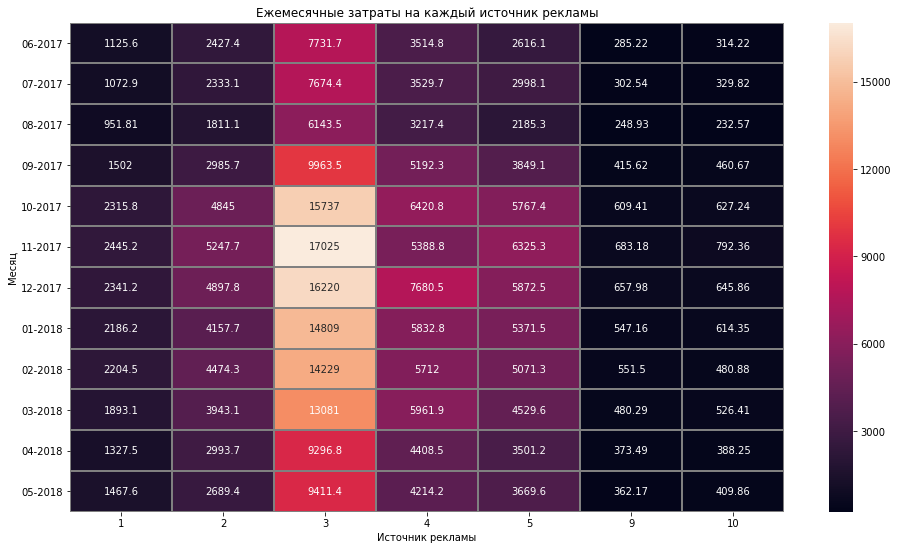

In [49]:
plt.figure(figsize=(16, 9))
plt.title('Ежемесячные затраты на каждый источник рекламы')
ax = sns.heatmap(source_month_pivot , annot=True, linewidths=1, fmt='.5g',linecolor='gray')
ax.set_yticklabels(for_heatmap.dt.strftime('%m-%Y'))
ax.set_ylabel('Месяц')
ax.set_xlabel('Источник рекламы')
plt.show()

Выводы:
   - Похоже, что все деньги уходят на `3` источник, посмотрим, как он покажет себя вдальнейшем анализе.
   - Затраты на рекламу увеличиваются начиная с `сентября` - `октября`, в разделе **Сколько раз покупают за период?** приводил предположение на этот счет (сезонность покупок).
   - Пиковые затраты приходятся предновогодние месяцы (`ноябрь` и `декабрь`)

### Сколько стоило привлечение одного покупателя из каждого источника?

В данном пункте нам необходимо рассчитать метрику CAC

In [50]:
#получу рекламный источник первого визита для каждого пользователя
uid_source = visits.sort_values('start_ts').groupby('uid').first().reset_index()
uid_source = uid_source[['uid','source_id']]

In [51]:
#склею рекламные источники с покупками
orders_w_source = orders.merge(uid_source, on = 'uid', how = 'left')

In [83]:
orders_w_source

,buy_ts,revenue,uid,buy_month,source_id,min_buy_date,buy_date
0,2017-06-01 00:10:00,17.00,10329302124590727494,2017-06-01,1,2017-06-01 00:10:00,2017-06-01
1,2017-06-01 00:25:00,0.55,11627257723692907447,2017-06-01,2,2017-06-01 00:25:00,2017-06-01
2,2017-06-01 00:27:00,0.37,17903680561304213844,2017-06-01,2,2017-06-01 00:27:00,2017-06-01
3,2017-06-01 00:29:00,0.55,16109239769442553005,2017-06-01,2,2017-06-01 00:29:00,2017-06-01
4,2017-06-01 07:58:00,0.37,14200605875248379450,2017-06-01,3,2017-06-01 07:58:00,2017-06-01
...,...,...,...,...,...,...,...
50409,2018-05-31 23:43:00,3.67,1805512004303848280,2018-05-01,2,2018-05-31 23:43:00,2018-05-31
50410,2018-05-31 23:50:00,4.64,12296626599487328624,2018-05-01,4,2018-05-31 23:50:00,2018-05-31
50411,2018-05-31 23:50:00,5.80,11369640365507475976,2018-05-01,10,2018-05-31 23:50:00,2018-05-31
50412,2018-05-31 23:54:00,0.30,1786462140797698849,2018-05-01,3,2018-05-31 23:54:00,2018-05-31


In [52]:
#получу получу дату и время первой покупки для каждого пользователя
buy_date = orders_w_source.groupby('uid')['buy_ts'].min().reset_index()
buy_date.columns = ['uid','min_buy_date']

In [53]:
orders_w_source = orders_w_source.merge(buy_date, on = 'uid',how = 'left')

In [54]:
orders_w_source = orders_w_source.query('buy_ts == min_buy_date')

In [55]:
#добавлю дату покупки
orders_w_source['buy_date'] = orders_w_source['buy_ts'].astype('datetime64[D]')

In [56]:
#получу количество покупателей в день, сгруппированных по источнику
buyers_in_day = orders_w_source.groupby(['source_id','buy_date'])['uid'].count().reset_index()
buyers_in_day.columns = ['source_id','dt','n_buyers']

In [57]:
#склею таблицу покупателей в день и затрат на маркетинг
costs_new = costs.merge(buyers_in_day, on =['source_id','dt'], how = 'inner')

In [58]:
#добавлю месяц, для дальнейей группировки
costs_new['month'] = costs_new['dt'].astype('datetime64[M]')

In [59]:
#получаю датасет для расчета CAC
for_cac = costs_new.groupby(['source_id','month'])['costs','n_buyers'].sum().reset_index()

In [60]:
#рассчет САС
for_cac['cac'] = for_cac['costs'] / for_cac['n_buyers']

In [61]:
cac_pivot = for_cac.pivot(index = 'month', columns = 'source_id', values = 'cac')

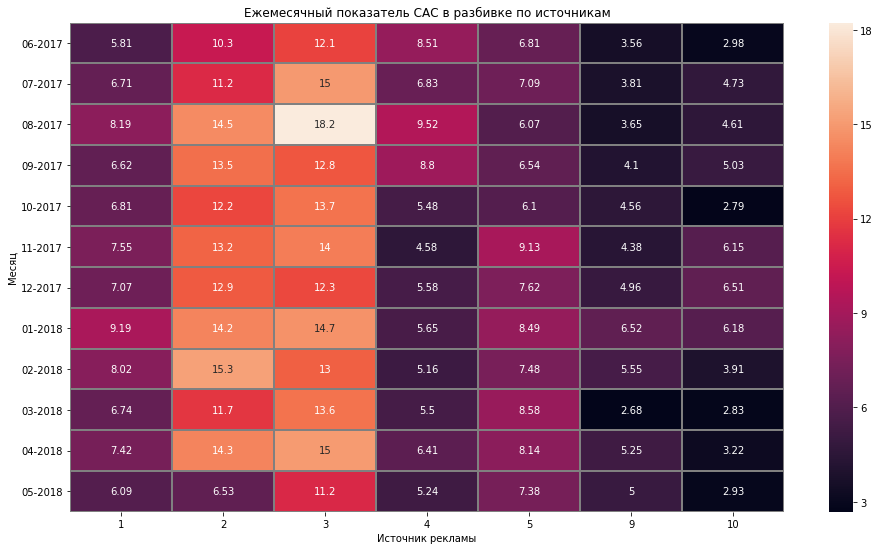

In [62]:
plt.figure(figsize=(16, 9))
plt.title('Ежемесячный показатель CAC в разбивке по источникам')
ax = sns.heatmap(cac_pivot , annot=True, linewidths=1, fmt='.3g',linecolor='gray')
ax.set_yticklabels(for_heatmap.dt.strftime('%m-%Y'))
ax.set_ylabel('Месяц')
ax.set_xlabel('Источник рекламы')
plt.show()

Выводы:

   - Самым затратным снова оказался источник `3`, можно предоложить, что затраты на него преувеличены

### На сколько окупились расходы? (ROI)

Сначала расчитаю время окупаемости когорт (**ROMI**)

In [64]:
orders_for_roi = orders_w_source.groupby(['source_id','buy_date']).agg({'uid':'count', 'revenue':'sum'}).reset_index()

In [65]:
costs_for_roi = costs_new.groupby(['month']).agg({'costs':'sum', 'n_buyers':'sum'}).reset_index()
costs_for_roi['cac']=costs_for_roi['costs']/costs_for_roi['n_buyers']
cac_for_roi = costs_for_roi[['month','cac','costs']]
cac_for_roi.columns = ['first_buy_month','cac','costs']

In [66]:
roi = cohort_ltv_full.merge(cac_for_roi, on = 'first_buy_month', how = 'left')

In [67]:
roi['romi'] = roi['ltv'] / roi['cac']

In [69]:
romi_pivot = (
    roi.pivot_table(
        index='first_buy_month',
        columns = 'age', 
        values = 'romi').cumsum(axis=1)
)

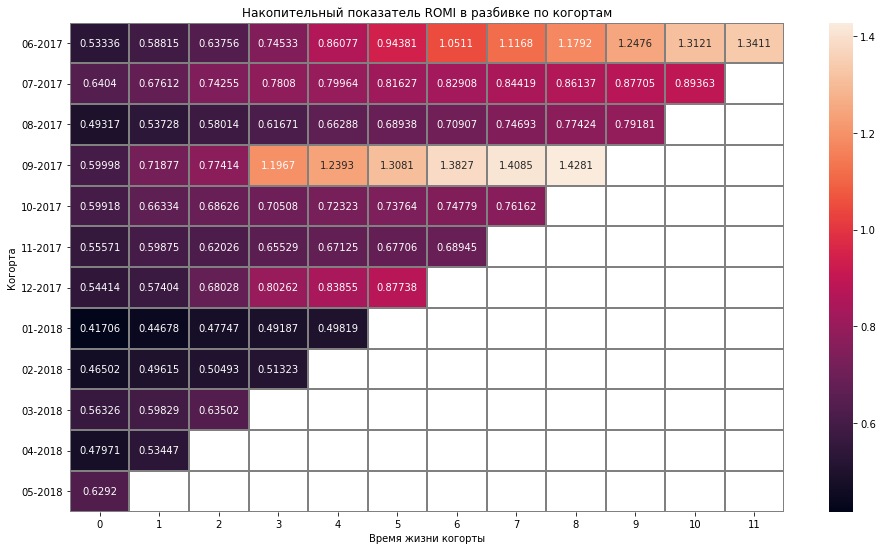

In [70]:
plt.figure(figsize=(16, 9))
plt.title('Накопительный показатель ROMI в разбивке по когортам')
ax = sns.heatmap(romi_pivot , annot=True, linewidths=1, fmt='.5g',linecolor='gray')
ax.set_yticklabels(for_heatmap.dt.strftime('%m-%Y'))
ax.set_ylabel('Когорта')
ax.set_xlabel('Время жизни когорты')
plt.show()

In [71]:
romi_pivot.mean(axis=0) 

age
0     0.543349
1     0.584740
2     0.633861
3     0.723074
4     0.786729
5     0.864233
6     0.901529
7     0.975604
8     1.060726
9     0.972154
10    1.102867
11    1.341098
dtype: float64

Вывод:

   - Окупились только 2 когорты (`июня и декабрь`)
   - В среднем, когорты окупаются за 8 месяцев.

Расчитаю показатель **ROMI** в разбивке по месяцам и источникам

In [72]:
orders_w_source2 = orders.merge(uid_source, on ='uid',how = 'left')

In [73]:
orders_w_source2['buy_month'] = orders_w_source2['buy_ts'].astype('datetime64[M]')

In [74]:
first_buy_month2 = orders_w_source2.groupby('uid').agg({'buy_month': 'min'}).reset_index()
first_buy_month2.columns = ['uid', 'first_buy_month']
orders_w_source2 = orders_w_source2.merge(first_buy_month,on = 'uid',how = 'left')

In [75]:
ltv2 = orders_w_source2.groupby(['first_buy_month','buy_month','source_id']).agg({'revenue': 'sum', 'uid':'count'}).reset_index()

In [76]:
costs['first_buy_month'] = costs['dt'].astype('datetime64[M]')
costs_for_merge = costs.groupby(['source_id','first_buy_month'])['costs'].sum().reset_index()

In [77]:
romi_final = ltv2.merge(costs_for_merge, on =['source_id','first_buy_month'], how = 'left')

In [78]:
romi_final['ltv'] = romi_final['revenue']/romi_final['uid']
romi_final['cac'] = romi_final['costs']/romi_final['uid']
romi_final['romi'] = romi_final['ltv']/romi_final['cac']

In [79]:
romi_pivot = (
    romi_final.pivot_table(
        index = 'first_buy_month',
        columns = 'source_id',
        values = 'romi').cumsum(axis=0)
)

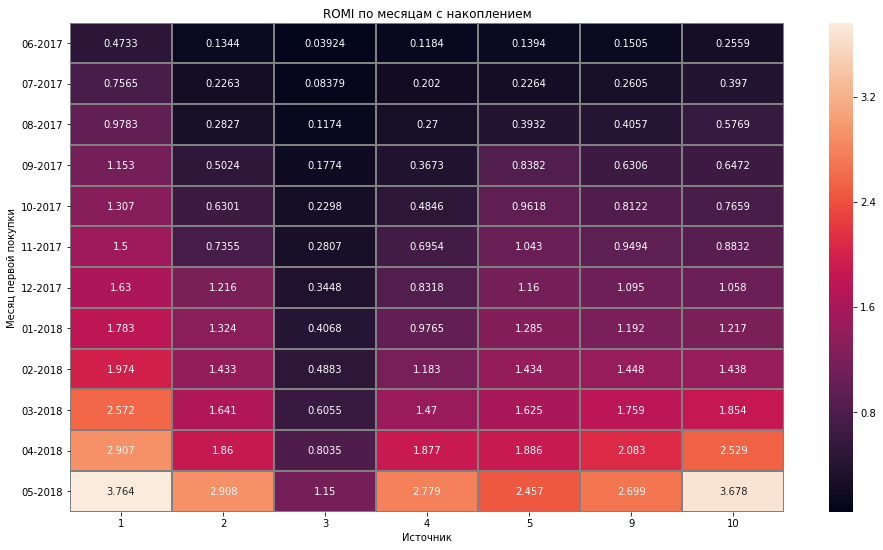

In [86]:
plt.figure(figsize=(16, 9))
plt.title('ROMI по месяцам с накоплением')
ax = sns.heatmap(romi_pivot, annot=True, linewidths=1, fmt='.4g',linecolor='gray')
ax.set_yticklabels(for_heatmap.dt.strftime('%m-%Y'))
ax.set_ylabel('Месяц первой покупки')
ax.set_xlabel('Источник')
plt.show()

Рассчитаю **ROI** каждого источника за весь период

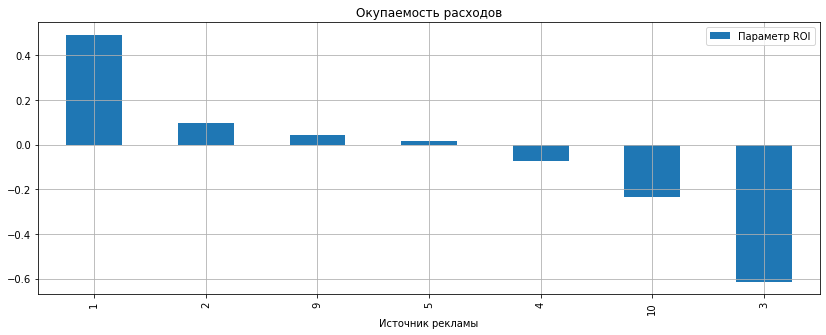

In [81]:
first_visit = visits.groupby('uid').agg({'start_ts':'min'})\
                .rename(columns={'start_ts':'first_date'})\
                .reset_index()

visits = visits.merge(first_visit, on ='uid')

visits_by_source = visits[visits['start_ts'] == visits['first_date']]

visits_by_source

costs_by_source = costs.groupby('source_id').agg({'costs':'sum'}).reset_index()

costs_by_source

revenue_by_source = (orders.merge(visits_by_source, on='uid', how='inner')).groupby('source_id').agg({'revenue':'sum'})

roi = revenue_by_source.merge(costs_by_source, on = 'source_id')
roi['roi'] = (roi['revenue'] - roi['costs']) / roi['costs']

roi

roi = roi.sort_values(by='roi',ascending = False).set_index('source_id')

ax = (roi['roi'].plot(kind = 'bar',grid = True, figsize = (14,5)))

ax.legend(['Параметр ROI'])
ax.set_title('Окупаемость расходов')
ax.set_xlabel('Источник рекламы')
plt.show()

# Итоговые выводы

 1. Мы загрузили, предобработали и подготовили для дальнейшей работы данные о посещениях, заказах, тратах на рекламу

 2. Были рассчитаны следующие метрики:
    
  - *Количество уникальных активных пользователей* в день (`907`), в неделю (`5716`), в месяц (`23228`);
  - *Среднее количество сессий в день* (`1.08`)
  - *Продолжительность сессии* (`половина сессий длятся не более 5 минут, а в 30 минут укладываются 92% сессий`)
  - *Коэффициент удержания* (`самый высокий результат был получен для когорт июня [первая когорта], августа, сентября, октября и ноября 2017 года`)
  - *Время, необходимое пользователям для совершения покупки* (`время нормально распрделено, без выбросов, наиболее часто покупки совершаются в  течении первых 5 минут`)
  - *Количество покупок в период* (`Наибольшее количество покупок было совершено с октября по декабрь`)
  - *Средний чек* (`5`)
  - *Сколько денег приносят пользователи,LTV* (`Самые прибыльные когорты: июнь и сентябрь 2017 года`)
  - *Сколько денег потратили на привлечение пользователей* (`Общее увеличение расходов на рекламу с октября по март; пик затрат приходится на предновогодние месяцы; самый дорогой источник под номером 3`)
  - *Сколько денег потратили на привлечение одного покупателя* (`Самые "дорогие" пользователи характерны для 3 и 10 источника`)
  - *На сколько окупились расходы, ROI* (`Наиболее окупаемым оказался источник 1, самый убыточный 3, предположительно перспективный источник 2`)
  
3. Рекомендации:

  - Исходя из распределения времени на совершение покупок - вряд ли пользователи испытывают какие то сложности с данной операцией
  - Я бы рекомендовал уделить большее внимание источникам рекламы `1`, как наиболее окупаемому, и `2`, как мне кажется перспективный по цене привлечения покупателя и, возможно только пока, минимальной окупаемости.
  - Возможно, стоит увеличить затраты на рекламу с октября по февраль, т.к. в эти месяцы довольно много происходит посещений и совершается покупок.